In [1]:
from IPython.core.display import HTML
css_file = 'css/ngcmstyle.css'
HTML(open(css_file, "r").read())

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw Python code, click <a href="javascript:code_toggle()">
[<code style="background-color:brown;color:yellow;"> here </code>]</a>.''')

Stochastical Model and Analysis
===
Effective Reproductive Number, $R_t$
---


Setting up early-warning system is very critical for discerning the subtle conditions of epidemidic changes and does help about making appropriate policy of public heath planning. A method based on estimating the effective reproductive number for epidemic early-warning is proposed.

According to the studies of **Coelho et al, [1,2,3]**, the effective reproductive number, $R_t$, could help to quantify the attack ratio of disease and  is a key to epidemiological inference and public health planning.

Our method is showcased in a data set consisting of 2015-2016 years of dengue incidence in the city of Tainan, Taiwan based on studies above.

Based on the studies on Bayesian result, [2], we use the estimated parameters to calculate $R_t$ as follows:

Let $Y_t$ be the number of reported disease cases for a particular time $t \in 
(0, T)$. and  $R_t$ is estimated as:
\begin{equation}
R_t = \left( \frac{Y_{t+1}}{Y_t}\right)^{1/n}
\end{equation}

where $n$ is taken to be the ratio between the length of reporting interval and 
the mean generation time of the disease. Here we are interested in the simpler case $n=1$.

The density of the induced Bayesian distribution is then 

\begin{equation}
f_P(R_t| a_1, b_1) = \frac{\Gamma(a_1 + b_1)}{\Gamma(a_1)\Gamma(b_1)} R_t^{a_1 - 1} (1 + R_t)^{-(a_1 + b_1)}
\end{equation}

where parameters, $(a_1,b_1)$, come from [2]. Thus, the expectation of $R_t$ is $a_1/(b_1 - 1)$ and its variance is 
$a_1(a_1 + b_1 - 1)/\left((b_1 - 2)(b_1 - 1)^2 \right) $.





In [14]:
%matplotlib inline

# pip install git+https://github.com/quantopian/qgrid
# conda install ipywidgets
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gmplot
import seaborn as sns
from ipywidgets import interact,widgets,interactive
from scipy.stats import beta
from IPython.display import display
from numpy import genfromtxt
from matplotlib import font_manager,rcParams
import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
df = pd.DataFrame.from_csv('data/test.csv',index_col=0,parse_dates=[0],encoding="utf-8")
df['date']=pd.to_datetime(df['date'])
df['num']=1

In [4]:
cases=df[['date','num','district']]

#  grouped data with respect to the date
cases_group = cases.groupby('date');

# calculate the accumulated number of cases
cases_totals = cases_group.sum()

In [5]:
cases_patterns = cases.set_index('date')
cases_Week=cases_patterns.resample('W',how=sum)
#purge the data at beginning
cases_Week_1=cases_Week[21:]

Parameters Estimation
---


In [9]:
def elicit_Rt_hyperpars(m0, v0 , c = .5): 
   if (v0==""):
      a0 = (m0**3*c**2 + m0**3 + m0**2)/(m0**2*c**2) 
      b0 = (2*m0**2*c**2 + m0**2 + m0)/(m0**2*c**2)
   else:
      a0 = (m0*v0 + m0**3 + m0**2)/v0
      b0 = (2*v0 + m0**2 + m0)/v0  
   return a0,b0


In [19]:
a0,b0=elicit_Rt_hyperpars(m0=0.5,v0=0.5)
print("Estimated a0 = " ,a0, "b0 = ",b0)

Estimated a0 =  1.25 b0 =  3.5


In [46]:
def ll(x):
    return x/(1-x)

def Rt_beta(d, gt = 3, alpha = .95, a0 = 2 , b0 = 3):
  ## Default a0 and b0 chosen so that E[R_t] = 1 and Var(R_t) = 2 
  ## gt = generation time, default 3 weeks
  ## alpha = *100% level of confidence
  N = len(d)
  d['Rt2']=0.;
  d['p1']=0.;
  d['LowTail']=0.;
  d['UpperTail']=0.; 
  ac = d[gt-1:]
  
  K = len(ac)
  jk1 = ac[1:K] # J[k+1] s
  jk  = ac[:(K-1)]# J[k]
  #print(K,(jk1) ,len(jk)) 
  for i in range(gt,N-1):
      d['Rt2'][i] =   (a0+jk1.num[i])/(jk.num[i] +b0-1) 
      #print(i,jk1.num[i],jk.num[i])
  #print(jk.num[0],jk1.num[0]/jk.num[0])

  for k in range(gt,N-1): 
      n=jk1.num[k] + jk.num[k]
      x=jk1.num[k]
      d['p1'][k] =  1-beta.cdf(.5,a=jk1.num[k] + a0,b=jk.num[k] + b0)  
      d['LowTail'][k] = ll(beta.ppf((1-alpha)/2,  a0 + x, b0 + n - x))
      d['UpperTail'][k]=ll( beta.ppf((1+alpha)/2, a0 + x, b0 + n - x))

In [47]:
Rt_beta(cases_Week_1,a0=a0,b0=b0)

Estimated $R_t$
---

In [48]:
# Rt calulated and created
cases_Week_1[:5]

,num,Rt2,p1,LowTail,UpperTail
date,,,,,
2015-06-07,1.0,0.000000,0.000000,0.000000,0.000000
2015-06-14,2.0,0.000000,0.000000,0.000000,0.000000
2015-06-21,2.0,0.000000,0.000000,0.000000,0.000000
2015-06-28,5.0,1.586957,0.854151,0.718804,3.119723
2015-07-05,10.0,1.500000,0.895148,0.817516,2.563534


(0, 3.2)

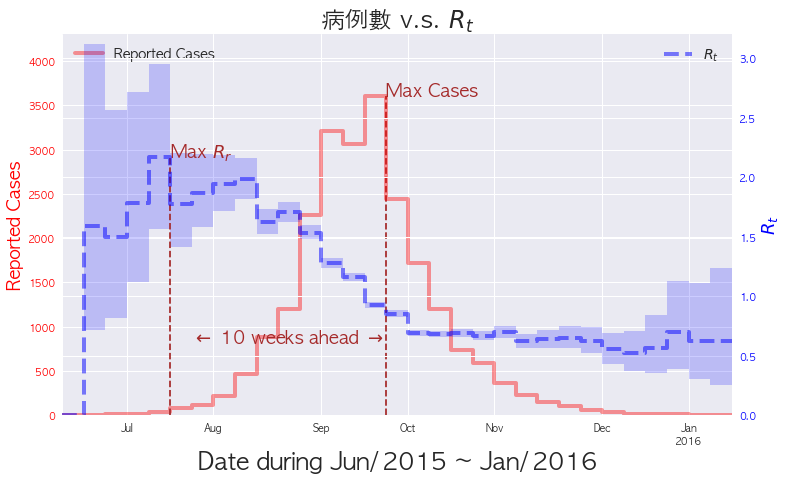

In [15]:
#rcParams['font.family'] = 'AR PL New Kai' 
# rcParams['font.family'] = 'LiHei Pro' 
rcParams['font.family'] = 'AppleGothic' 

fig, ax1 = plt.subplots(figsize=(12,7))
cases_Week_1['num'].plot(color="red",label='Reported Cases',drawstyle='steps',alpha=0.4,linewidth=4)
ax1.set_ylabel('Reported Cases',fontsize=18, color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
cases_Week_1['Rt2'][1:-1].plot(color="blue",label='$R_t$',drawstyle='steps',style='--',linewidth=4,alpha=0.5)
ax2.fill_between(cases_Week_1.index, cases_Week_1.UpperTail, cases_Week_1.LowTail, \
                 step='pre', facecolor='blue', alpha=.2)

# Make the y-axis label and tick labels match the line color.

ax2.vlines(x=[cases_Week_1.index[6]],ymin=0,ymax=cases_Week_1['Rt2'].max(),color='brown',linestyle='--')
ax2.text(x=cases_Week_1.index[7],y=0.6,s='$\leftarrow$ 10 weeks ahead $\\rightarrow$',size=18,color='brown')
ax2.text(x=cases_Week_1.index[6],y=cases_Week_1['Rt2'].max(),s='Max $R_r$',size=18,color='brown')

ax2.set_ylabel('$R_t$',fontsize=18, color='b')
for t2 in ax2.get_yticklabels():
    t2.set_color('b')
ax1.vlines(x=[cases_Week_1.index[16]],ymin=0,ymax=cases_Week_1['num'].max(),color='brown',linestyle='--')
ax1.text(x=cases_Week_1.index[16],y=cases_Week_1['num'].max(),s='Max Cases',size=18,color='brown')

ax1.legend(fontsize=14,loc='upper left')  
ax2.legend(fontsize=14)  

ax1.set_title(u'病例數 v.s. $R_t$',fontsize=24)   
ax1.set_xlabel('Date during Jun/2015 ~ Jan/2016',fontsize=24)  
ax1.set_ylim([0,4300])
ax2.set_ylim([0,3.2])

Results and Discussion
---
Since there is very limited information, (data from Tainan city goverment), regarding the actual proportions of each virus in circulation and most information available is about the predominant serotypes for some epidemics in the period of study only, we propose the use of a simplified a single strain model only with the variability introduced by the co-circulation of multiple serotypes and heterogeneous levels of immunity in the general population taken into account.

Hence, we propose a method to bypass the lack of serotype-specific case data by informing the time-varying force of infection with the instantaneous reproductive number, $R_t$ which we calculate from aggregated data.

- <font color="brown">As expected, uncertainty about $R_t$ is **greater** when the case counts are low, for instance in the period during July 2015, which represented a big hiatus between major epidemics. The intrinsic variability of $R_t$ can be used to inform the time-varying force of infection, since it reflects variation in the vector population and other environmental factors such as temperature and seasonal variation.</font>
- $R_t$ is used to inform a dynamic epidemic model with time-varying force of infection in order to gain insight into the attack ratio of each epidemic;  
- Attack Ratio estimates are provided for last year of Dengue epidemics in Tainan, Taiwan.
- The developed method to quantify uncertainty about $R_t$ is readily applicable to continuous monitoring and other diseases. 


References
---
1.  Coelho, F. C., Codec ̧o, C. T. & Gomes, M. G. A Bayesian framework for parameter estimation in
dynamical models. PLoS ONE 6, e19616 (2011).

2.  Coelho1, Flavio Codeço  & Luiz Max de Carvalho, Estimating the Attack Ratio of
Dengue Epidemics under Time-varying Force of Infection using Aggregated Notification Data, Nature 5, 18455 (2015).

3. Nishiura, H., Chowell, G., Heesterbeek, H. & Wallinga, J. The ideal reporting interval for an epidemic to objectively interpret the epidemiological time course. J R Soc Interface 7, 297–307 (2010).

In [51]:
cases_Week_1.to_csv("data/taiwan-2016-Rt-2.csv")